В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [58]:
class NeuralNet:
    def __init__(self,hidden_layer, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.hidden_layer = hidden_layer
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x):
        self.parameters = {}
        l = len(n_x)
        
        for i in range(1, l):
            W = np.random.randn(n_x[i], n_x[i - 1]) * 0.01
            b = np.zeros((n_x[i], 1))
            self.parameters.update({f"W{i}": W, f"b{i}": b})

        W = np.random.randn(1, n_x[l-1]) * 0.01
        b = 0
        
        self.parameters.update({f"W{l}":W, f"b{l}":b})
        
    def __forward_propagation(self, X):
        layers_count = len(self.hidden_layer)
        cache = self.parameters.copy()
        
        A = X
        for i in range(1, layers_count + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            Z = np.dot(W, A) + b
            A = self.__sigmoid(Z)
            cache.update({f"Z{i}": Z})
            cache.update({f"A{i}": A})
        return A, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        layers_count = len(self.hidden_layer)
        
        grads = {}
        A = cache[f"A{layers_count+1}"]
        A_next = cache[f"A{layers_count}"]
                
        dZ = A - Y
        dW = 1. / m * np.dot(dZ, A_next.T)
        db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
        grads.update({f"dZ{layers_count+1}":dZ, f"dW{layers_count+1}":dW, f"db{layers_count+1}":db})
        for i in range(layers_count, 0, -1):
            W = cache[f"W{i}"]
            b = cache[f"b{i}"]
            Z = cache[f"Z{i}"]
                
            if (i == 1):
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                dA = np.dot(W_prev.T, dZ)

                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, X.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            else:
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]

                dA = np.dot(W_prev.T, dZ)
                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            grads.update({f"dZ{i}":dZ, f"dW{i}":dW, f"db{i}":db})
        return grads
    
    def __update_parameters(self, grads):
        layers_count = len(self.hidden_layer)
        
        for i in range(1, layers_count + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            
            dW = grads[f"dW{i}"]
            db = grads[f"db{i}"]
            
            self.parameters[f"W{i}"] = W - self.learning_rate * dW
            self.parameters[f"b{i}"] = b - self.learning_rate * db

        
    def fit(self, X_vert, Y_vert, epsilon,print_cost = True):
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = (X.shape[0],) + self.hidden_layer
        
        self.__initialize_parameters(n_x)
        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
            costs.append(cost)
            
            # break condition
            if i > 1 and abs(costs[-2] - costs[-1]) < epsilon:
                break
                
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        print(probs)
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [59]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [60]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


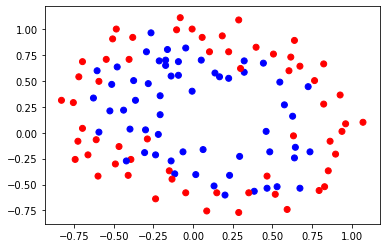

In [61]:
plot_data(X, Y)

In [91]:
cls = NeuralNet((40,),normalize = True, learning_rate = 0.5, num_iter = 9000)

0-th iteration: 0.693033740242625
1000-th iteration: 0.6899614845428892
2000-th iteration: 0.5923636389665558
3000-th iteration: 0.41382362981360576
4000-th iteration: 0.35729325005916995
5000-th iteration: 0.32067432080894803
6000-th iteration: 0.2985717775814122
7000-th iteration: 0.2823498663577451
8000-th iteration: 0.26994729219230523


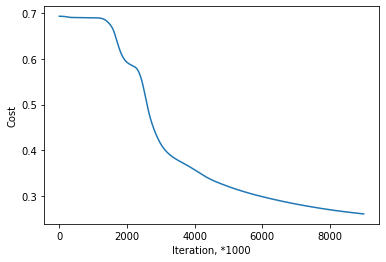

In [92]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)), 10e-15)

In [93]:
print(cls.parameters)

{'W1': array([[ 0.20678751,  0.04112589],
       [ 0.63459127, -0.15512337],
       [ 0.51614322, -0.09631706],
       [ 1.04543558, -1.74312833],
       [ 0.21078523,  0.0389858 ],
       [ 0.52623659, -0.103795  ],
       [ 0.34607108, -0.03035147],
       [ 4.46776165,  1.08075605],
       [ 0.51231817, -0.13700477],
       [ 0.48722892, -0.08689235],
       [ 0.45036193, -0.07395111],
       [ 0.55773401, -0.03611429],
       [ 0.59532229,  0.01619636],
       [-4.31885607, -1.07005596],
       [ 2.04620241,  5.22185676],
       [ 0.32657216, -0.06595777],
       [-0.24467738,  0.72175391],
       [ 0.62216463,  3.17819884],
       [ 0.57291047, -0.12303807],
       [ 0.35001857, -0.06331173],
       [ 0.47691786, -0.08426503],
       [ 0.24679102,  0.01960776],
       [-0.11424787,  0.8782344 ],
       [ 0.04753353,  0.09594148],
       [ 0.39950855, -0.11531128],
       [-1.22412453, -0.10564563],
       [ 1.08605126, -2.07033569],
       [ 0.26184669,  0.01166017],
       [-2.35

In [94]:
Y_prob = cls.predict_proba(X)
Y_prob

[[0.60208819 0.89555067 0.08059289 0.06203999 0.04897394 0.87124966
  0.04618744 0.20837321 0.67081108 0.95411302 0.99996184 0.32163224
  0.31303027 0.01242101 0.90108939 0.11044275 0.82298067 0.97478585
  0.97374744 0.07964129 0.99999803 0.83343079 0.93024886 0.00699215
  0.35296504 0.99338286 0.21813157 0.09389006 0.49152382 0.95064338
  0.99956984 0.56326513 0.29906782 0.99255159 0.01899438 0.37156414
  0.34794359 0.03698904 0.99999992 0.08571679 0.00673111 0.51524919
  0.00114946 0.11125517 0.23611866 0.98354471 0.06588254 0.03938932
  0.1387093  0.01707725 0.85622036 0.03374841 0.99869305 0.00127321
  0.4429567  0.00656753 0.00772982 0.87436972 0.5310595  0.81218486
  0.59762475 0.99978418 0.00513338 0.54890062 0.99888044 0.98392641
  0.01225539 0.10566328 0.43042779 0.01788766 0.99989532 0.84948205
  0.99908754 0.90315566 0.78785164 0.99999248 0.3289156  0.89250217
  0.45585233 0.75072545 0.09140104 0.99999673 0.99997303 0.45226202
  0.20309675 0.69447888 0.00803711 0.00629492 0.

array([[6.02088189e-01, 3.97911811e-01],
       [8.95550672e-01, 1.04449328e-01],
       [8.05928903e-02, 9.19407110e-01],
       [6.20399920e-02, 9.37960008e-01],
       [4.89739435e-02, 9.51026057e-01],
       [8.71249662e-01, 1.28750338e-01],
       [4.61874396e-02, 9.53812560e-01],
       [2.08373207e-01, 7.91626793e-01],
       [6.70811083e-01, 3.29188917e-01],
       [9.54113018e-01, 4.58869824e-02],
       [9.99961844e-01, 3.81557132e-05],
       [3.21632240e-01, 6.78367760e-01],
       [3.13030269e-01, 6.86969731e-01],
       [1.24210110e-02, 9.87578989e-01],
       [9.01089390e-01, 9.89106103e-02],
       [1.10442750e-01, 8.89557250e-01],
       [8.22980674e-01, 1.77019326e-01],
       [9.74785853e-01, 2.52141474e-02],
       [9.73747442e-01, 2.62525584e-02],
       [7.96412908e-02, 9.20358709e-01],
       [9.99998034e-01, 1.96646485e-06],
       [8.33430790e-01, 1.66569210e-01],
       [9.30248861e-01, 6.97511394e-02],
       [6.99215276e-03, 9.93007847e-01],
       [3.529650

In [95]:
Y_hat = cls.predict(X)
Y_hat

[[0.60208819 0.89555067 0.08059289 0.06203999 0.04897394 0.87124966
  0.04618744 0.20837321 0.67081108 0.95411302 0.99996184 0.32163224
  0.31303027 0.01242101 0.90108939 0.11044275 0.82298067 0.97478585
  0.97374744 0.07964129 0.99999803 0.83343079 0.93024886 0.00699215
  0.35296504 0.99338286 0.21813157 0.09389006 0.49152382 0.95064338
  0.99956984 0.56326513 0.29906782 0.99255159 0.01899438 0.37156414
  0.34794359 0.03698904 0.99999992 0.08571679 0.00673111 0.51524919
  0.00114946 0.11125517 0.23611866 0.98354471 0.06588254 0.03938932
  0.1387093  0.01707725 0.85622036 0.03374841 0.99869305 0.00127321
  0.4429567  0.00656753 0.00772982 0.87436972 0.5310595  0.81218486
  0.59762475 0.99978418 0.00513338 0.54890062 0.99888044 0.98392641
  0.01225539 0.10566328 0.43042779 0.01788766 0.99989532 0.84948205
  0.99908754 0.90315566 0.78785164 0.99999248 0.3289156  0.89250217
  0.45585233 0.75072545 0.09140104 0.99999673 0.99997303 0.45226202
  0.20309675 0.69447888 0.00803711 0.00629492 0.

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [96]:
accuracy_score(Y, Y_hat)

0.864406779661017

[[0.00030147 0.00031085 0.00032165 ... 0.00228823 0.00229953 0.00229953]]


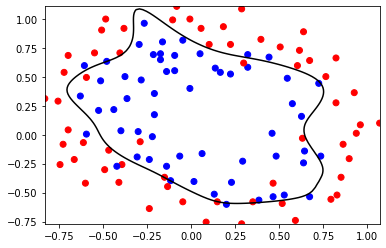

In [97]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [99]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (40,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [100]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(40,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

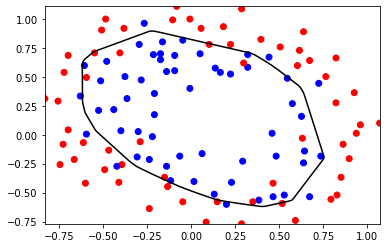

In [101]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [102]:
accuracy_score(Y, clf.predict(X))

0.847457627118644